In [160]:
from astropy.coordinates import SkyCoord, EarthLocation, Angle, Latitude, Longitude
from astropy.coordinates import get_moon
from datetime import datetime, timedelta
from shapely.geometry import Point
from astropy import units as u
from astropy.time import Time
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
import numpy as np
import webbrowser
import sqlite3

In [129]:
#Coordinates of Green Bank Telescope (Telescope used in Observation)
coordinates = EarthLocation.of_site('GBT')
print(coordinates)

(882598.25131862, -4924862.65979072, 3943712.65334219) m


## Generate A Time Range for Given Observation

In [130]:
#Create an Observation Time Range
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta
        
def observation_timerange(start_year, start_month, start_day, start_hour, end_year, end_month, end_day, end_hour):
    #Time Range Year, Month, Day, Hour, Min
    dts = [dt.strftime('%Y-%m-%dT%H:%M') for dt in datetime_range(datetime(start_year, start_month, start_day, start_hour, 0), datetime(end_year, end_month, end_day, end_hour, 0), timedelta(minutes=60))]
    #Get Julian Days for Zenith Conversion Below
    JulianDays = []
    for i in dts:
        dt = datetime.strptime(i, '%Y-%m-%dT%H:%M')
        con = sqlite3.connect(":memory:")
        JulianDays = np.append(JulianDays, list(con.execute("select julianday('" +i[:-6]+ "')"))[0][0])
    return dts, JulianDays

**Input Given Observation Time Range Below**
- dts represents an array of observation time
- JulianDays represent the dts array converted to julian day

In [131]:
dts, JulianDays = observation_timerange(2015, 11, 1, 1, 2015, 11, 1, 2)

## Generate Moon Position For Each Element In DTS

In [132]:
#Example of Moon Position Over a Timerange 
mooncord = get_moon(Time(dts, format='isot', scale='utc'), coordinates)

In [133]:
#Example of a SkyCoord for a Specific Time, 
mooncord[0]

<SkyCoord (GCRS: obstime=['2015-11-01T01:00:00.000'], obsgeoloc=[(4539328.42523617, -2117392.25396233, 3936657.06836955)] m, obsgeovel=[(154.38880808, 330.57207763, -0.2212721)] m / s): (ra, dec, distance) in (deg, deg, km)
    (99.79149625, 17.33599765, 382670.07799037)>

In [134]:
#Get Right Ascention or Declinnation by going coord.ra or coord.dec
mooncord[0].ra

<Longitude 99.79149625 deg>

# Approach to Calculating Moon Sub-Point

Given a date and time, the position of the Moon can be calculated to provide the declination and right ascension. The sub-point of the Moon (the point on the Earth at which the Moon is at the zenith) is as follows:

- latitude = declination of the Moon

- longitude can be found by calculating the local mean sidereal time (LMST) that equals the Moon's right ascension. (LMST dependents on the date, time, and longitude.) Everything is known except for the longitude.

## Method (using GMST)

- Calculate the Local Mean Sidereal Time (LMST) where GMST is the Greenwich Mean Sidereal Time and 𝑙𝑜𝑛𝑔𝑒𝑎𝑠𝑡 is the longitude with positive values in the eastern hemisphere

   **𝐿𝑀𝑆𝑇=𝐺𝑀𝑆𝑇+𝑙𝑜𝑛𝑔𝑒𝑎𝑠𝑡**
   

- The Astronomical Almanac gives an expression for approximate mean sidereal time, in hours: 

    GMST=6.697374558+0.06570982441908 𝐷 +1.00273790935 𝐻 +0.000026 𝑇^2
    

- Where GMST is the mean sidereal time in hours, 𝐻 is the universal time at the time in question, 𝐷0 is the Julian date on the previous midnight of the time in question less 2451545.0, 𝐷 is the Julian date at the time in question (including fractional days) less 2451545.0, and 𝑇 is 𝐷/36525. The relationship between 𝐷0 is quite simple: 𝐷0=𝐷−𝐻/24. Substituting this in the above and omitting the quadratic term yields

    GMST=6.697374558+0.06570982441908(𝐷0−𝐻/24)+1.00273790935𝐻
    
        =6.697374558+0.06570982441908𝐷+𝐻
    
- Multiplying by 15 yields the GMST in degrees:

    **GMST_deg=100.4606184+0.9856473662862𝐷+15𝐻**
 





In [144]:
#Generate Lat, Long Sub-Point Based on the Method Described Above of all Observation Times
def moonSubPoint(mooncord):
    lat, long, JD = [], [], 2451545
    for i in range(len(mooncord)):
        Time = dts[i]
        lat = np.append(lat, float(str(mooncord[i].dec*u.degree)[:-5]))
        LMST = float(str(mooncord[i].ra*u.degree)[:-4])%360
        D = JulianDays[i] - JD
        GMST = (100.4606184 + 0.9856473662862 * D + 15*int(Time[11:13]))%360
        print(Time, "LMST:", LMST, "GMST:", GMST)
        temp = LMST - GMST 
        if temp < -180:
            temp = 360 + temp
        elif temp > 180:
            temp = temp - 360
        long = np.append(long, temp)
    return lat, long 

lat, long = moonSubPoint(mooncord)

2015-11-01T01:00 LMST: 99.7914962465863 GMST: 54.96651394995206


## Graphing Moon Sub-Point

In [136]:
data = {'Longitude': long,'Latitude': lat, 'Observation Time UTC': dts, 'Type': []}
df = pd.DataFrame(data, columns = ['Longitude','Latitude', 'Observation Time UTC'])
calculations = df

In [137]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

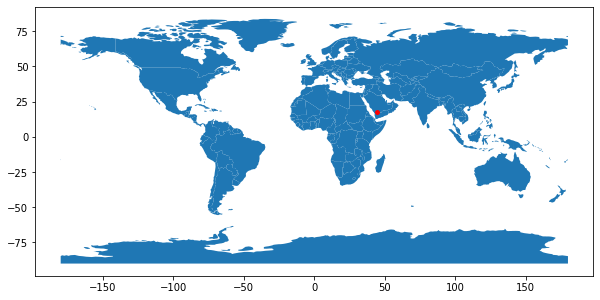

In [138]:
#Shows Moon Subpoint 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

## Generate A Corresponding Region of Potential Signals

In [146]:
df2= df[0:1]
moonlong = df2['Longitude'].loc[0]
moonlat = df2['Latitude'].loc[0]
obstime = df2['Observation Time UTC'].loc[0]
df2 = df2.iloc[:, :-1]
df2
#Example of Dataframe row below 

,Longitude,Latitude,Observation Time UTC
0,44.824982,17.335998,2015-11-01T01:00


In [147]:
#Setting Edges of For Possible Signal Region
if moonlong +90 > 180:
    df2.loc[1] = [moonlong-180, moonlat, obstime]
else:
    df2.loc[1] = [moonlong+90, moonlat, obstime]
if moonlong -90 < -180:
    df2.loc[2] = [180 - abs(moonlong - 90 + 180), moonlat, obstime]
else:
    df2.loc[2] = [moonlong-90, moonlat, obstime]
#Setting Sides of Moon Lat
if moonlat +90 > 90:
    df2.loc[3] = [moonlong, moonlat-90, obstime]
else:
    df2.loc[3] = [moonlong, moonlat+45, obstime]

In [148]:
geometry = [Point(xy) for xy in zip(df2['Longitude'], df2['Latitude'])]
gdf = GeoDataFrame(df2, geometry=geometry)   
gdf

,Longitude,Latitude,Observation Time UTC,geometry
0,44.824982,17.335998,2015-11-01T01:00,POINT (44.82498 17.33600)
1,134.824982,17.335998,2015-11-01T01:00,POINT (134.82498 17.33600)
2,-45.175018,17.335998,2015-11-01T01:00,POINT (-45.17502 17.33600)
3,44.824982,-72.664002,2015-11-01T01:00,POINT (44.82498 -72.66400)


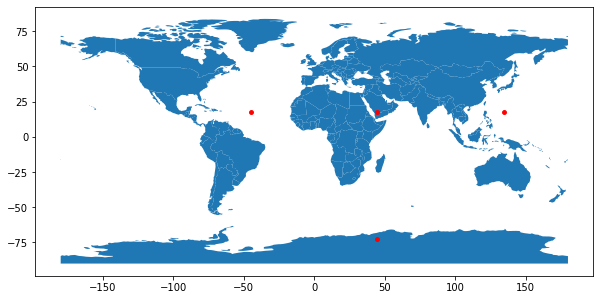

In [149]:
#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

## Clean Transmitter Data Convert DDMMSS -> Degrees

In [121]:
transmitters = pd.read_excel('DTV-Channels US.xlsx', index_col=None, header=None) 
transmitters = transmitters.rename(columns=transmitters.iloc[0])
transmitters = transmitters.iloc[1:]
transmitters
#Latitude in DDMMSS, Longitude in DDDMMSS

,#,Dir,ST,Area,City of License (if other),Call Sign,Netw. (Primary),A. CH,Vir. CH,ERP (kW),...,MT Angle,Latitude,Longitude,Big 4,Facility ID #,Area (sq km),Pop. (1000),Location,ASRN,Antenna Model
1,1,-,NY,NEW YORK,NaN,WCBS,CBS,2,2.1,45,...,-,404454,735910,x,9610,26765,19217,ESB - UHF Combiner (ESBTUF80),NaN,NaN
2,1,-,NY,NEW YORK,NaN,WPIX,CW,11,11.1,123,...,-,404454,735910,NaN,73881,26002,19228,ESB - VHF Combiner,NaN,THA-O4-2H/8UD2SP-2-HM (DIE)
3,1,-,NJ,NEW YORK,NEWARK,WNET,PBS,13,13.1,123,...,-,404454,735910,NaN,18795,25695,19240,ESB - VHF Combiner,NaN,NaN
4,1,E,NY,NEW YORK,GARDEN CITY,WLIW,PBS,21,21.1,2735,...,-,404719,732709,NaN,38336,10930,13638,NaN,NaN,NaN
5,1,-,NY,NEW YORK,NaN,WNYE,ind.,25,25.1,2450,...,-,404522,735912,NaN,6048,20860,18221,4 Times Square,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1807,VI1,NaN,VI,CHARLOTTE AMALIE,NaN,WTJX,PBS,12,12.1,28.8,...,-,182128,645653,NaN,70287,18332,11,NaN,NaN,NaN
1808,VI1,NaN,VI,CHARLOTTE AMALIE,NaN,WVXF,CBS,17,17.1,75.9,...,NaN,182126,645650,x,3113,24541,104,NaN,NaN,NaN
1809,VI1,NaN,VI,CHARLOTTE AMALIE,NaN,WZVI,ABC,43,43.1,NaN,...,NaN,182043,645545,x,83270,1687,0,NaN,NaN,NaN
1810,VI2,NaN,VI,CHRISTIANSTED,NaN,WSVI,ABC,8,8.1,200,...,NaN,174521,644756,x,2370,17484,7,NaN,NaN,NaN


In [126]:
# Convert DDMMSS/DDDMMSS To Degrees Given A Pandas df As Input
def ddmmss_deg(df):
    for index, row in df.iterrows():
         lat = str(row['Latitude'])
         long = str(row['Longitude'])
         row['Latitude'] = float(lat[:2]) + float(lat[2:4])/60 + float(lat[4:6])/(60*60)
         if len(long) == 6:
            temp = float(long[:2]) + float(long[2:4])/60 + float(long[4:6])/(60*60)
            if temp + 180 > 180 :
                row['Longitude'] = -180 + abs(temp - 180)
            else:
                row['Longitude'] = temp
         else:
            temp = float(long[:3]) + float(long[3:5])/60 + float(long[5:7])/(60*60)
            if temp + 180 > 180:
                row['Longitude'] = -180 + abs(temp -  180)
            else:
                row['Longitude'] = temp
    return df

In [123]:
transmitters = ddmmss_deg(transmitters)
transmitters

,#,Dir,ST,Area,City of License (if other),Call Sign,Netw. (Primary),A. CH,Vir. CH,ERP (kW),...,MT Angle,Latitude,Longitude,Big 4,Facility ID #,Area (sq km),Pop. (1000),Location,ASRN,Antenna Model
1,1,-,NY,NEW YORK,NaN,WCBS,CBS,2,2.1,45,...,-,40.7483,-73.9861,x,9610,26765,19217,ESB - UHF Combiner (ESBTUF80),NaN,NaN
2,1,-,NY,NEW YORK,NaN,WPIX,CW,11,11.1,123,...,-,40.7483,-73.9861,NaN,73881,26002,19228,ESB - VHF Combiner,NaN,THA-O4-2H/8UD2SP-2-HM (DIE)
3,1,-,NJ,NEW YORK,NEWARK,WNET,PBS,13,13.1,123,...,-,40.7483,-73.9861,NaN,18795,25695,19240,ESB - VHF Combiner,NaN,NaN
4,1,E,NY,NEW YORK,GARDEN CITY,WLIW,PBS,21,21.1,2735,...,-,40.7886,-73.4525,NaN,38336,10930,13638,NaN,NaN,NaN
5,1,-,NY,NEW YORK,NaN,WNYE,ind.,25,25.1,2450,...,-,40.7561,-73.9867,NaN,6048,20860,18221,4 Times Square,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1807,VI1,NaN,VI,CHARLOTTE AMALIE,NaN,WTJX,PBS,12,12.1,28.8,...,-,18.3578,-64.9481,NaN,70287,18332,11,NaN,NaN,NaN
1808,VI1,NaN,VI,CHARLOTTE AMALIE,NaN,WVXF,CBS,17,17.1,75.9,...,NaN,18.3572,-64.9472,x,3113,24541,104,NaN,NaN,NaN
1809,VI1,NaN,VI,CHARLOTTE AMALIE,NaN,WZVI,ABC,43,43.1,NaN,...,NaN,18.3453,-64.9292,x,83270,1687,0,NaN,NaN,NaN
1810,VI2,NaN,VI,CHRISTIANSTED,NaN,WSVI,ABC,8,8.1,200,...,NaN,17.7558,-64.7989,x,2370,17484,7,NaN,NaN,NaN


In [124]:
geometry = [Point(xy) for xy in zip(transmitters['Longitude'], transmitters['Latitude'])]
gdftransmitters = GeoDataFrame(transmitters, geometry=geometry)   

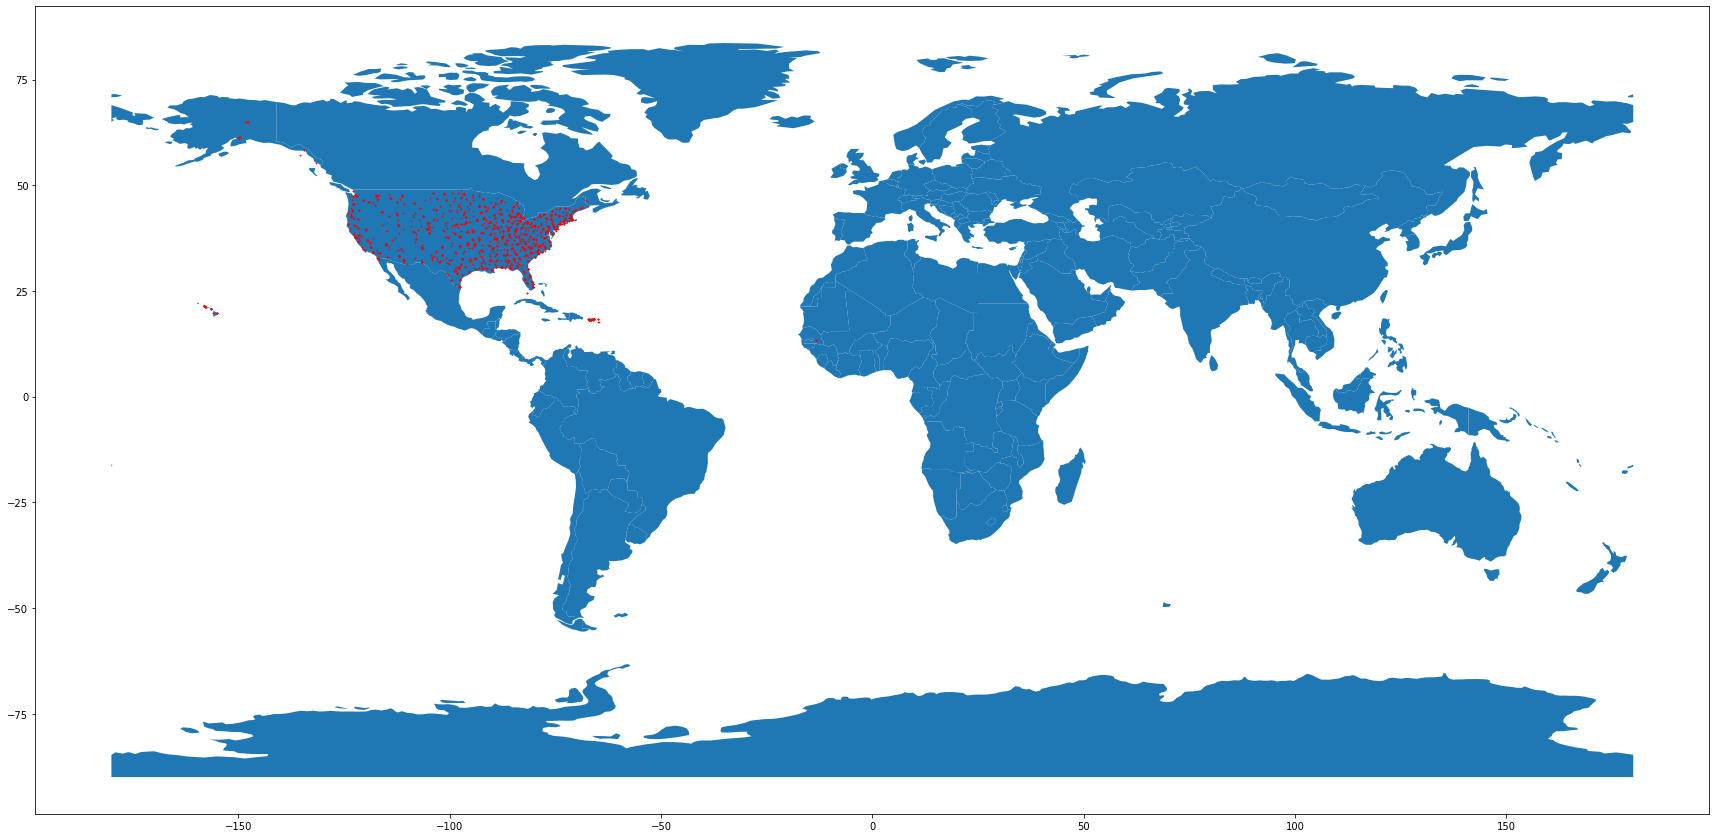

In [125]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdftransmitters.plot(ax=world.plot(figsize=(30, 18)), marker='o', color='red', markersize=.5);

## More Global Transmitter Data
-  Source: https://www.nautel.com/about/nautel-radio-transmitter-world-map/

In [93]:
trans = pd.read_json('transmitters.json')

In [94]:
trans

,id,company,address,city,state,country,longitude,latitude,owner,power,frequency,website,story,photo,model1,model2,model3,service,status
0,2875,KCUK,NaN,Chevak,AK,UNITED STATES,-165.586,61.5278,KASHUNAMIUT SCHOOL DISTRICT,6.0,88.1,None,None,None,None,None,NaN,FM,NaN
1,4194,FAA FORT DAVIS,NaN,Nome,AK,UNITED STATES,-165.406,64.5011,None,NaN,NaN,None,None,None,None,None,NaN,None,NaN
2,4195,KICY,NaN,Nome,AK,UNITED STATES,-165.406,64.5011,ARCTIC BROADCASTING ASSOCIATION,50.0,850.0,None,None,None,None,None,NaN,AM,NaN
3,4196,KNOM,NaN,Nome,AK,UNITED STATES,-165.406,64.5011,CATHOLIC BISHOP OF NORTHERN ALASKA,25.0,780.0,None,None,None,None,None,NaN,AM,NaN
4,3644,KINU,NaN,Kotzebue,AK,UNITED STATES,-162.597,66.8983,KOTZEBUE BROADCASTING INC.,0.1,89.9,None,None,None,None,None,NaN,FM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5319,1835,1YZ,NaN,Tauranga,None,NEW ZEALAND,176.165,-37.6878,None,NaN,NaN,None,None,None,None,None,NaN,None,NaN
5320,1836,1ZD,NaN,Tauranga,None,NEW ZEALAND,176.165,-37.6878,None,NaN,NaN,None,None,None,None,None,NaN,None,NaN
5321,1821,RADIONZ,NaN,Napier,None,NEW ZEALAND,176.912,-39.4928,None,NaN,NaN,None,None,None,None,None,NaN,None,NaN
5322,1107,FIJI BROADCASTING,NaN,Suva,None,FIJI,178.424,-18.1419,None,NaN,NaN,None,None,None,None,None,NaN,None,NaN


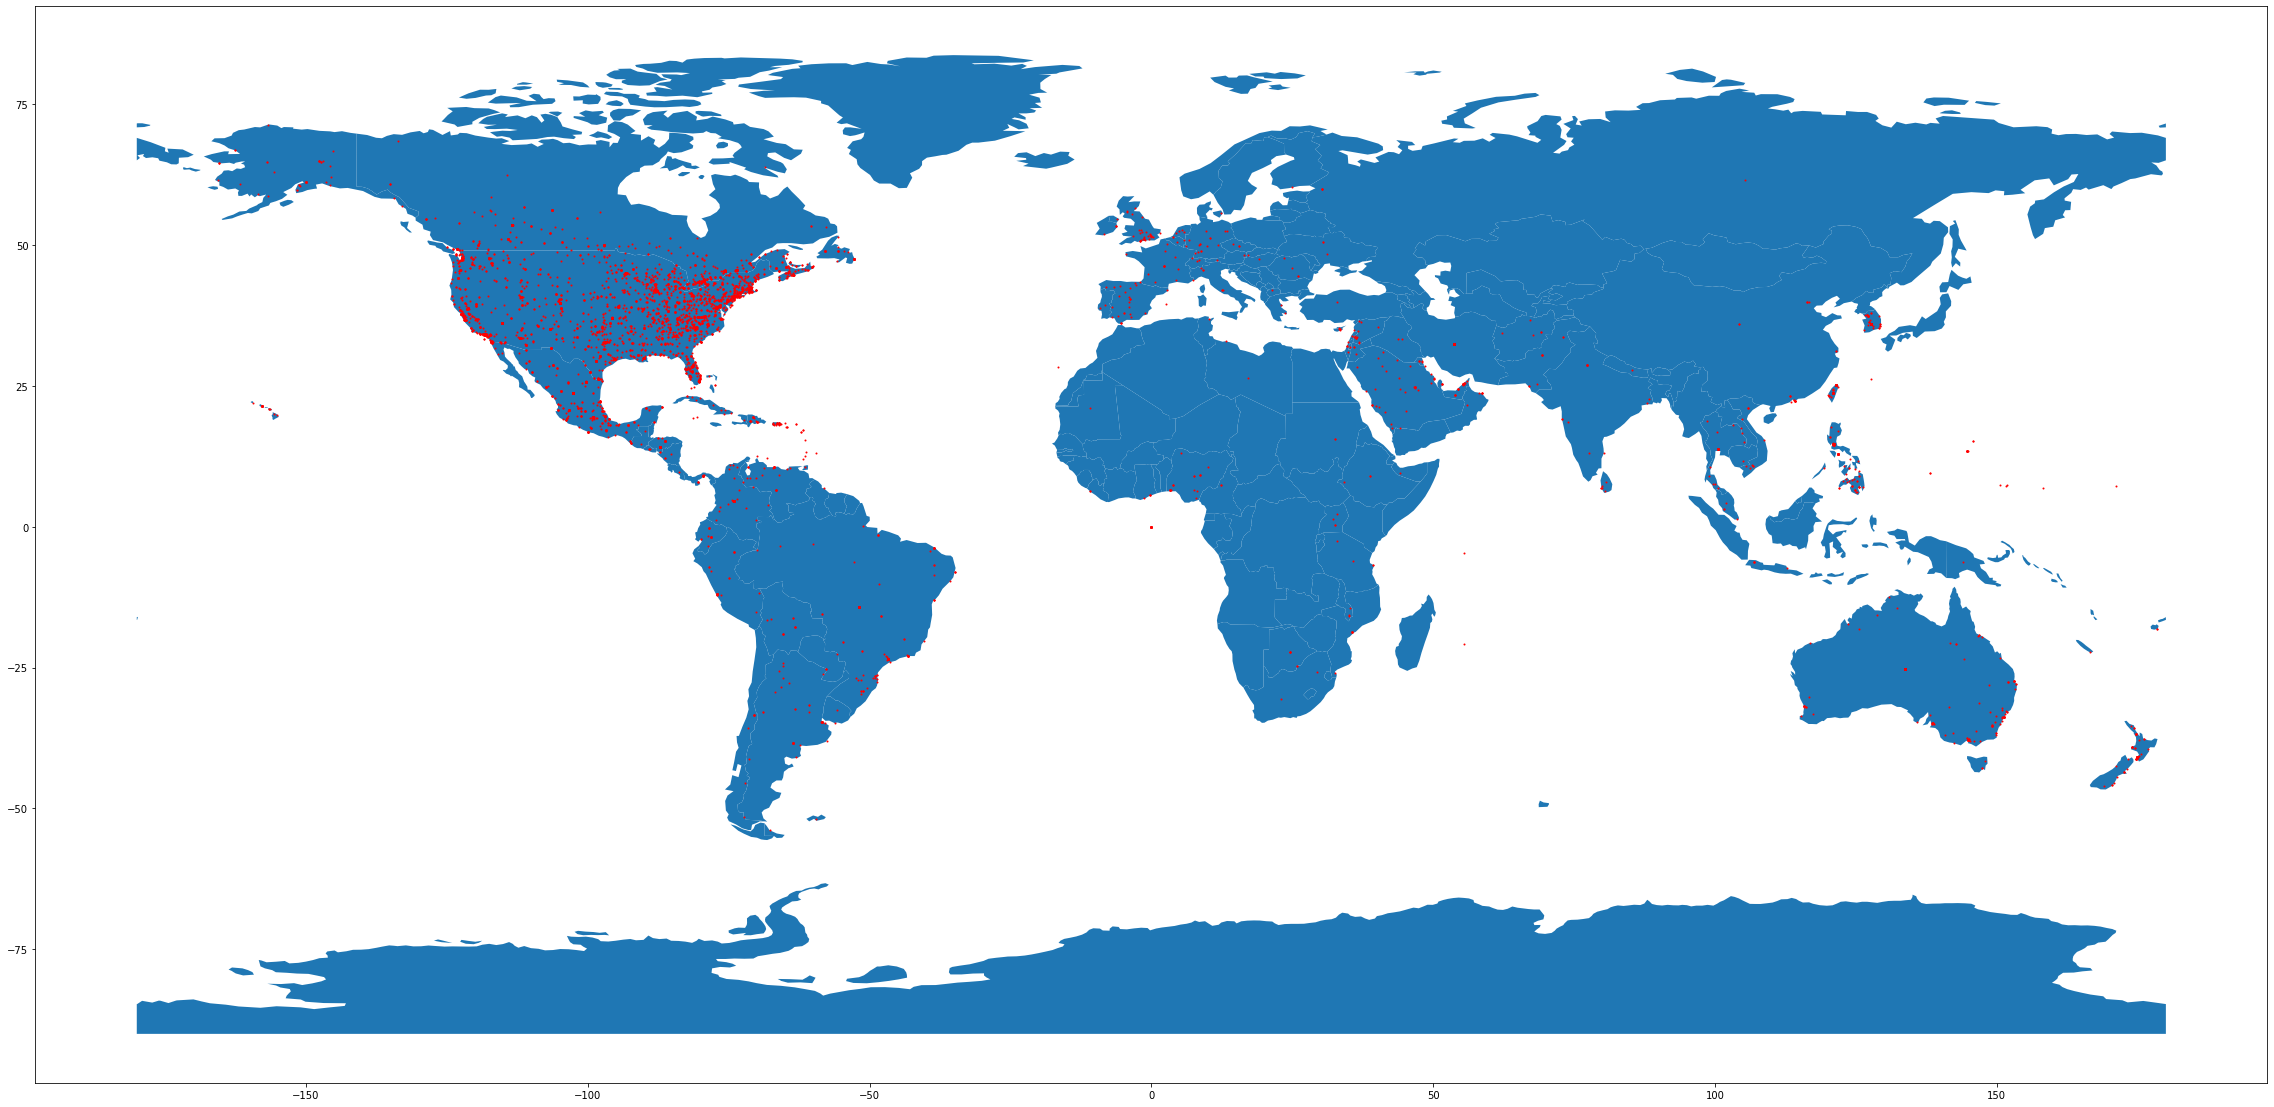

In [153]:
geometry = [Point(xy) for xy in zip(trans['longitude'], trans['latitude'])]
gdftransmitters = GeoDataFrame(trans, geometry=geometry)  
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdftransmitters.plot(ax=world.plot(figsize=(40, 24)), marker='o', color='red', markersize=1);

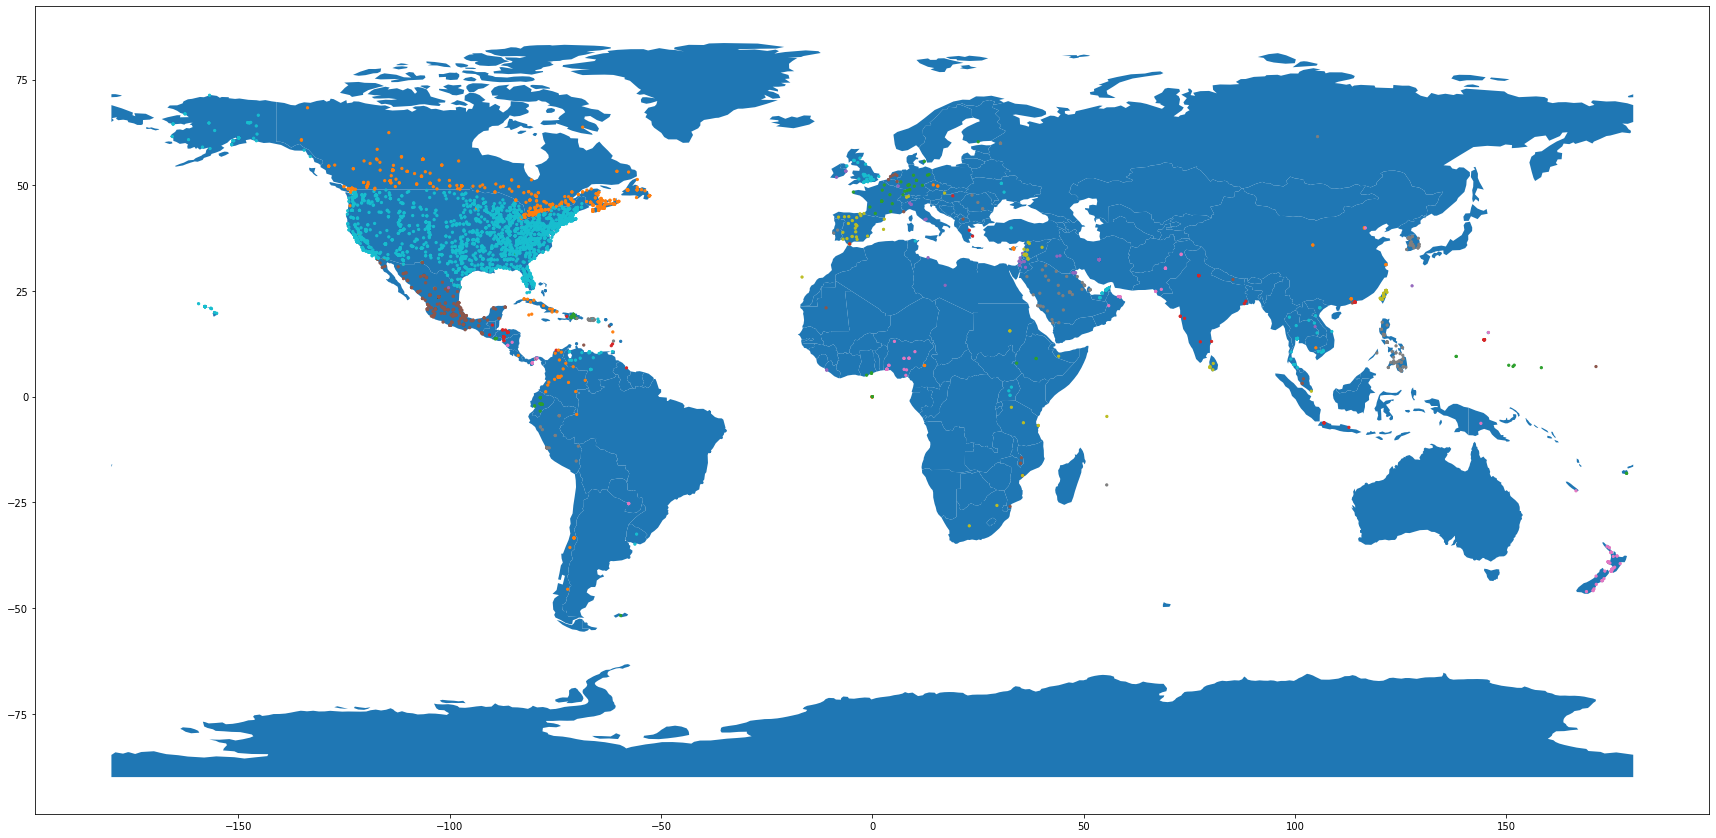

In [178]:
#Distinguishes Bewteen Transmitter Locations For Different Countries
#Set lengend = True to show country color key
gdftransmitters.plot(column='country', ax=world.plot(figsize=(30, 18)), legend=False, markersize=5)